In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
import wrf
import netCDF4 as nc
import tqdm
import xarray as xr
import glob
warnings.simplefilter("ignore")

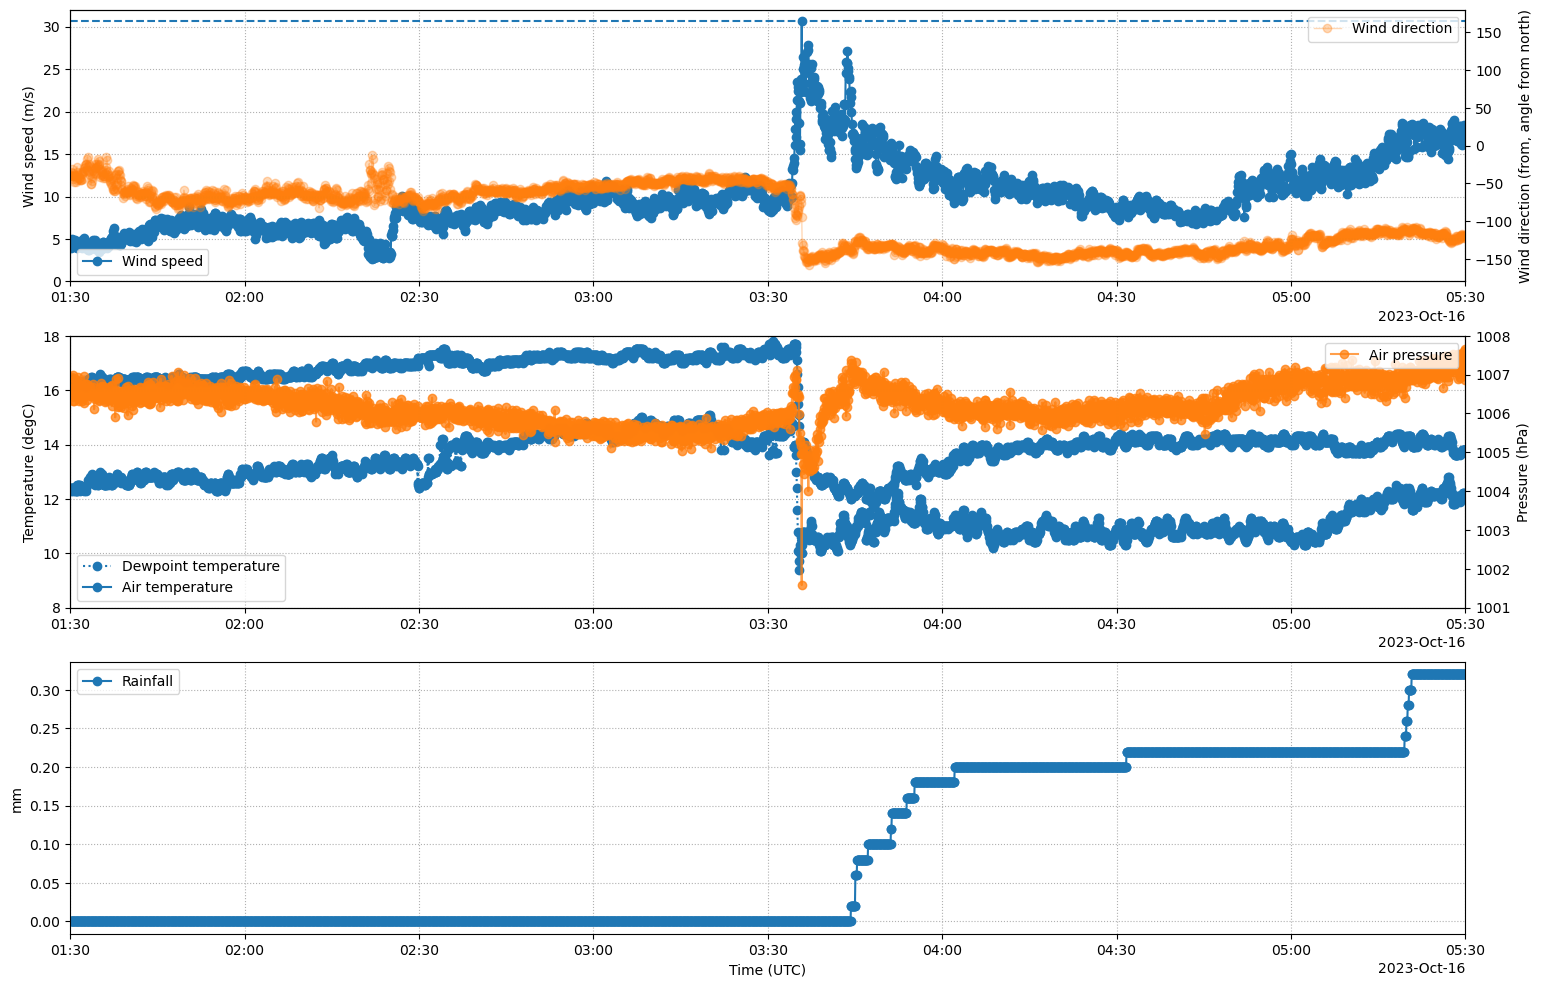

In [7]:
def plot_met_data(da_windspeed,
                  da_winddir,
                  da_airpressure,
                  da_dewpt,
                  da_airtemp,
                  da_rain,
                  t1,
                  t2,
                  ws_ax,
                  temp_ax,
                  rain_ax,
                  zero_to_360=True,title="",
                  pres_lim=None,temp_lim=None,speed_lim=None,sst=False,
                  fname_sst=[""],radiation=False,ccn=False,fname_ccn=[""],plot_lat=False,fname_lat=[""],vert_lines=False):
    

    ax2 = ws_ax.twinx()
    da_windspeed.plot(label="Wind speed",ax=ws_ax,marker="o")
    ws_ax.axhline(da_windspeed.values.max(),color="tab:blue",ls="--")
    if zero_to_360:
        dir1 = da_winddir.values
        lims = [0,360]
    else:
        dir1 = (da_winddir.values + 180) % 360 - 180
        lims = [-180,180]
    ax2.plot(da_windspeed.time.values,dir1,color="tab:orange",lw=1,alpha=0.3,label="Wind direction",marker="o")
    ax2.set_ylim(lims)
    ws_ax.legend(loc=3)
    ax2.legend(loc=1)
    ws_ax.grid(ls=":")
    ws_ax.set_title(title)
    ws_ax.set_ylim(speed_lim)
    ws_ax.set_ylabel("Wind speed (m/s)")
    ax2.set_ylabel("Wind direction (from, angle from north)")
    ws_ax.set_xlabel("")
    if vert_lines:
        [ws_ax.axvline(pd.to_datetime(t),ls=":",color="k") for t in vert_lines]
    ws_ax.set_xlim([pd.to_datetime(t1),pd.to_datetime(t2)])

    ax2 = temp_ax.twinx()
    da_airpressure.plot(color="tab:orange",ls="-",label="Air pressure",ax=ax2,alpha=0.75,marker="o")
    da_dewpt.plot(color="tab:blue",ls=":",label="Dewpoint temperature",ax=temp_ax,marker="o")
    da_airtemp.plot(color="tab:blue",ls="-",label="Air temperature",ax=temp_ax,marker="o")
    
    temp_ax.legend(loc=3)
    ax2.legend(loc=1)
    temp_ax.grid(ls=":")
    temp_ax.set_ylim(temp_lim)
    ax2.set_ylim(pres_lim)
    temp_ax.set_ylabel("Temperature (degC)")
    ax2.set_ylabel("Pressure (hPa)")
    temp_ax.set_xlabel("")

    if vert_lines:
        [temp_ax.axvline(pd.to_datetime(t),ls=":",color="k") for t in vert_lines]
    temp_ax.set_xlim([pd.to_datetime(t1),pd.to_datetime(t2)])

    da_rain.plot(ax=rain_ax,color="tab:blue",label="Rainfall",marker="o")
    rain_ax.set_ylabel("mm")
    rain_ax.set_xlabel("Time (UTC)")
    rain_ax.grid(ls=":")
    rain_ax.legend(loc=2)

    if vert_lines:
        [rain_ax.axvline(pd.to_datetime(t),ls=":",color="k") for t in vert_lines]
    rain_ax.set_xlim([pd.to_datetime(t1),pd.to_datetime(t2)])

    if vert_lines:
        [rain_ax.axvline(pd.to_datetime(t),ls=":",color="k") for t in vert_lines]

#    plt.savefig("/Volumes/Voyages/current/science/radiosonde/figs/"+title+".jpeg",dpi=100,bbox_inches="tight")

def underway_hourly_rain_to_accumulation(da_rain):

    diff = da_rain.diff("time",1)
    return diff.where(diff > 0, 0).cumsum()

fname_met = ["/g/data/w40/ab4502/IN2023_V06/data/underway/20231015-213339-metstation-met_01.met"]
fname_weather = ["/g/data/w40/ab4502/IN2023_V06/data/underway/20231015-213339-weather-met_01.met"]
t1 = "2023-10-16 01:30"
t2 = "2023-10-16 05:30"
title=""
pres_lim = [1001,1008]
speed_lim = [0,32]
temp_lim = [8,18]

ds_met = xr.concat([xr.open_dataset(f) for f in fname_met],"time").sel(time=slice(t1,t2))
ds_weather = xr.concat([xr.open_dataset(f) for f in fname_weather],"time").sel(time=slice(t1,t2))

da_windspeed = ds_weather.anemtruewindspeed / 1.944
da_winddir = ds_weather.anemtruewinddir
da_airpressure = ds_weather.airpressure
da_dewpt = ds_weather.dewpt
da_airtemp = ds_weather.airtemp
da_rain = (underway_hourly_rain_to_accumulation(ds_weather.starboardcumulativehourrain) + \
           underway_hourly_rain_to_accumulation(ds_weather.portcumulativehourrain)) / 2


plt.figure(figsize=[18,12])
plot_met_data(da_windspeed, da_winddir, da_airpressure, da_dewpt, da_airtemp, da_rain
    ,t1,t2,plt.subplot(3,1,1),plt.subplot(3,1,2),plt.subplot(3,1,3),zero_to_360=False,title=title,pres_lim=pres_lim,temp_lim=temp_lim,speed_lim=speed_lim)

In [3]:
def preprocess(f):
    
    time_strs = [str(i.values)[1:].replace("_"," ") for i in f.Times]
    time_datetime = pd.to_datetime(time_strs)
    f = f.assign(Time=time_datetime)
    
    return f

lat,lon = [-36.73, 154.30]

sfcwind_f = xr.open_mfdataset("/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa_shortlead/sfcwind_d04_2023-10-16_0*",
                      decode_times=False,concat_dim="Time",combine="nested",preprocess=preprocess)
sfcwind_f["ws"] = np.sqrt(np.square(sfcwind_f["U10"]) + np.square(sfcwind_f["V10"]))
sfcwind_times = sfcwind_f.Time.values
sfcwind_wrflist = nc.Dataset("/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa_shortlead/sfcwind_d04_2023-10-16_06:00:00")

highres_f = xr.open_mfdataset("/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa_shortlead/highres_d04_2023-10-16_0*",
                      decode_times=False,concat_dim="Time",combine="nested",preprocess=preprocess)
highres_times = highres_f.Time.values
highres_wrflist = [nc.Dataset(f) for f in np.sort(glob.glob("/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa_shortlead/highres_d04_2023-10-16_0*"))]

wrfout_f = xr.open_mfdataset("/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa_shortlead/wrfout_d04_2023-10-16_0*",
                      decode_times=False,concat_dim="Time",combine="nested",preprocess=preprocess)
wrfout_times = highres_f.Time.values
wrfout_wrflist = [nc.Dataset(f) for f in np.sort(glob.glob("/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa_shortlead/wrfout_d04_2023-10-16_0*"))]

In [4]:
x, y = wrf.ll_to_xy(sfcwind_wrflist,lat,lon).values
sfcwind_f = sfcwind_f.sel(south_north=y,west_east=x)
highres_f = highres_f.sel(south_north=y,west_east=x)
wrfout_f = wrfout_f.sel(south_north=y,west_east=x)

In [5]:
wrf_windspeed = sfcwind_f.ws
wrf_winddir = ((180 + (180/np.pi)*np.arctan2(sfcwind_f["V10"],sfcwind_f["U10"])) % 360)
wrf_airpressure = highres_f["PSFC"] / 100
wrf_rain = highres_f["RAINNC"]
wrf_rain = wrf_rain - wrf_rain.values[0]
wrf_dewpt = xr.concat([wrf.getvar(highres_wrflist,"td",timeidx=t).sel(bottom_top=0,south_north=y,west_east=x) for t in tqdm.tqdm(range(len(highres_wrflist)))], dim="Time")
wrf_airtemp = xr.concat([wrf.getvar(highres_wrflist,"tc",timeidx=t).sel(bottom_top=0,south_north=y,west_east=x) for t in tqdm.tqdm(range(len(highres_wrflist)))], dim="Time")

100%|██████████| 60/60 [03:52<00:00,  3.87s/it]


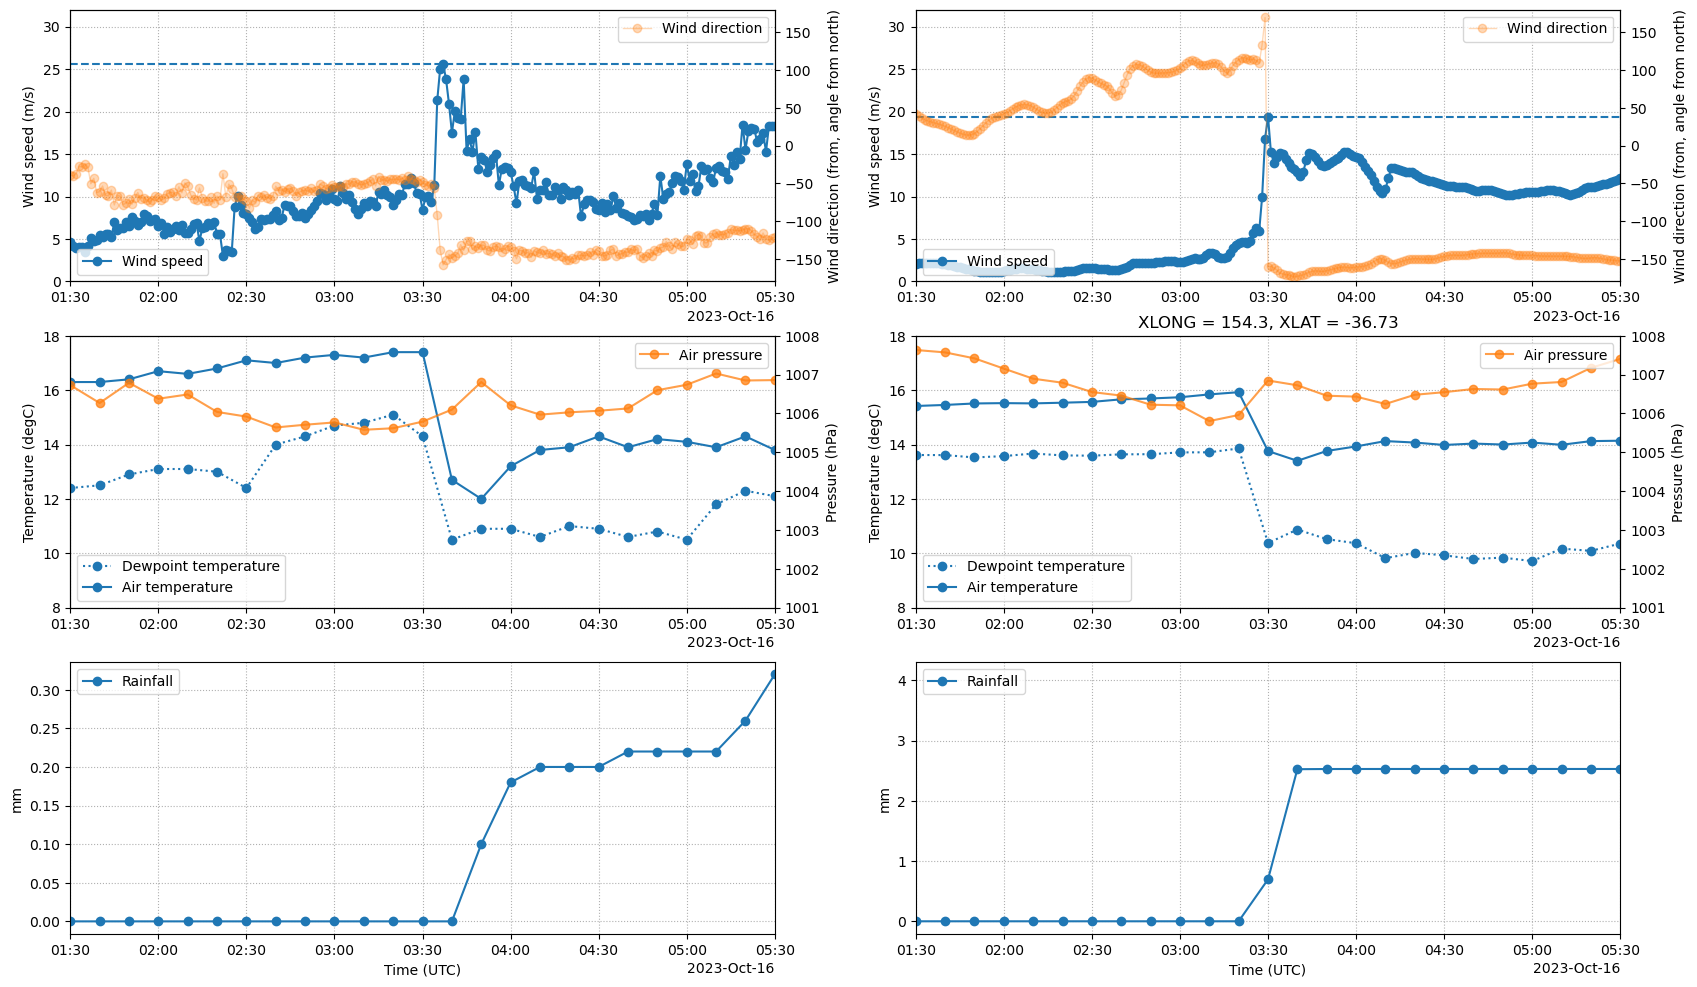

In [8]:
plt.figure(figsize=[20,12])

plot_met_data(da_windspeed.resample({"time":"min"}).first(),
              da_winddir.resample({"time":"min"}).first(), 
              da_airpressure.resample({"time":"10min"}).first(), 
              da_dewpt.resample({"time":"10min"}).first(), 
              da_airtemp.resample({"time":"10min"}).first(),
              da_rain.resample({"time":"10min"}).first()
    ,t1,t2,plt.subplot(3,2,1),plt.subplot(3,2,3),plt.subplot(3,2,5),zero_to_360=False,title=title,pres_lim=pres_lim,temp_lim=temp_lim,speed_lim=speed_lim)

plot_met_data(wrf_windspeed.rename({"Time":"time"}),
              wrf_winddir.rename({"Time":"time"}), 
              wrf_airpressure.rename({"Time":"time"}), 
              wrf_dewpt.rename({"Time":"time"}), 
              wrf_airtemp.rename({"Time":"time"}),
              wrf_rain.rename({"Time":"time"}) 
    ,t1,t2,plt.subplot(3,2,2),plt.subplot(3,2,4),plt.subplot(3,2,6),zero_to_360=False,title=title,pres_lim=pres_lim,temp_lim=temp_lim,speed_lim=speed_lim)